In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_A.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_A'], dtype=object)

In [6]:
data_std.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_A'] 
X = data_std.drop(['Coeff_A','Name'], axis=1)

### Using CV technique

RF
R2:  0.9118765251199213
RMSE:  0.29685598339949054
---------------------------------------
GB
R2:  0.9140997583712241
RMSE:  0.29308743000813914
---------------------------------------
LR
R2:  -1.577791307886829e+24
RMSE:  1256101631193.4434
---------------------------------------
RR
R2:  0.6185594280577644
RMSE:  0.6176087531295485
---------------------------------------
LASSO
R2:  0.9216307567538624
RMSE:  0.27994507183756173
---------------------------------------
gpr1
R2:  0.9185348357039973
RMSE:  0.28542102987692175
---------------------------------------
gpr2
R2:  0.9394492158419159
RMSE:  0.24607068935182855
---------------------------------------
gpr3
R2:  0.9053735620351536
RMSE:  0.3076141056012327
---------------------------------------
gpr4
R2:  0.9053735562730424
RMSE:  0.3076141149670438
---------------------------------------
gpr5
R2:  0.9314387114277034
RMSE:  0.2618421061867181
---------------------------------------
gpr6
R2:  0.8790536729054462
RMSE:  0.3477733846

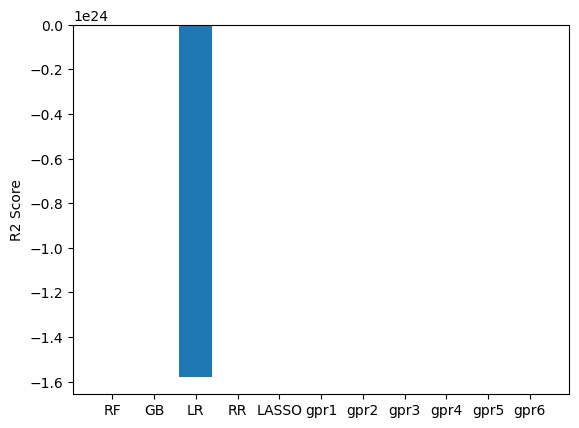

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature       Score
14     X_EA  112.702665
2       X_Z  106.612941
22   X_Rvdw   86.120704
11   X_IEII   80.598055
20   A_Rvdw   56.376662
6     A_IEI   38.414491
18   A_ChiA   35.147717
32     B_Hf   18.081523
15   A_ChiP   17.250853
5       X_G   15.282633
26     B_MP   14.690246
24     B_Ra   13.703676
25     A_MP   13.495857
12     A_EA   11.836644
0       A_Z   11.590484
1       B_Z   11.204890
35  X_Kappa    9.959958
36    A_CvM    8.849576
33  A_Kappa    8.078728
34  B_Kappa    7.615863
31     X_MV    7.419386
30     B_MV    7.256271
38      A_B    5.603181
3       A_G    4.843449
28    B_Rho    4.738198
37    B_CvM    4.631709
13     B_EA    3.862307
8     X_IEI    3.594946
21   B_Rvdw    3.269603
23     B_Rc    2.595919


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'A_ChiP', 'X_G', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'A_Z',
       'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_Kappa', 'X_MV', 'B_MV',
       'A_B', 'A_G', 'B_Rho', 'B_CvM', 'B_EA', 'X_IEI', 'B_Rvdw', 'B_Rc',
       'B_ChiP', 'B_IEII', 'A_Rho', 'B_G', 'B_IEI', 'X_Rho',
       'B_MendeleevNo', 'B_ChiA', 'X_ChiP', 'A_IEII'], dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9084209144248825
RMSE:  0.3026203654335206
---------------------------------------
GB
R2:  0.8983164856737229
RMSE:  0.3188785259723162
---------------------------------------
LR
R2:  -4.608415157410372e+22
RMSE:  214672195624.17422
---------------------------------------
RR
R2:  0.5918458683950686
RMSE:  0.6388694167080871
---------------------------------------
LASSO
R2:  0.9165994241329998
RMSE:  0.28879157859432153
---------------------------------------
gpr1
R2:  0.9173175390870902
RMSE:  0.28754558058316565
---------------------------------------
gpr2
R2:  0.9396680601421693
RMSE:  0.24562560912459985
---------------------------------------
gpr3
R2:  0.9064833790838922
RMSE:  0.30580487392471
---------------------------------------
gpr4
R2:  0.9064833964076625
RMSE:  0.3058048455998327
---------------------------------------
gpr5
R2:  0.9329470628757556
RMSE:  0.2589458188970125
---------------------------------------
gpr6
R2:  0.8804001474261297
RMSE:  0.34583211616891

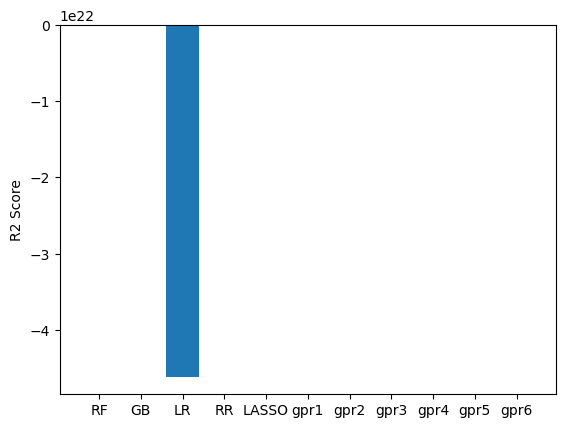

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'A_ChiP', 'X_G', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'A_Z',
       'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_Kappa', 'X_MV', 'B_MV',
       'A_B', 'A_G', 'B_Rho', 'B_CvM', 'B_EA', 'X_IEI', 'B_Rvdw', 'B_Rc'],
      dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.9145894496136227
RMSE:  0.2922508347060403
---------------------------------------
GB
R2:  0.907939502511378
RMSE:  0.30341472852948653
---------------------------------------
LR
R2:  -1.2110999551998889e+20
RMSE:  11004998660.608229
---------------------------------------
RR
R2:  0.9001774707411323
RMSE:  0.3159470355278993
---------------------------------------
LASSO
R2:  0.920657875941001
RMSE:  0.2816773403364192
---------------------------------------
gpr1
R2:  0.9208706710184739
RMSE:  0.28129935830272734
---------------------------------------
gpr2
R2:  0.9448348794389021
RMSE:  0.23487256238457901
---------------------------------------
gpr3
R2:  0.9103943440854033
RMSE:  0.29934203833507367
---------------------------------------
gpr4
R2:  0.9103943330997206
RMSE:  0.2993420566847889
---------------------------------------
gpr5
R2:  0.9389534204759772
RMSE:  0.24707606020013928
---------------------------------------
gpr6
R2:  0.904487021752941
RMSE:  0.309051740404

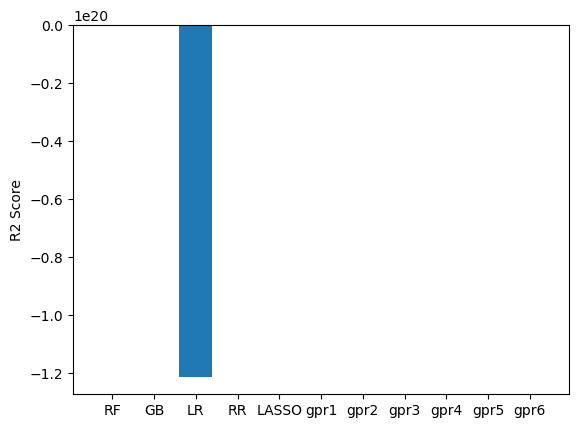

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'A_ChiP', 'X_G', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'A_Z',
       'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_Kappa'], dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9171128038509241
RMSE:  0.2879013653129765
---------------------------------------
GB
R2:  0.9187151806947536
RMSE:  0.2851049268343962
---------------------------------------
LR
R2:  0.8880515505304055
RMSE:  0.33458698341327403
---------------------------------------
RR
R2:  0.8879054453782081
RMSE:  0.33480524879665763
---------------------------------------
LASSO
R2:  0.9038128230555375
RMSE:  0.31014057610132634
---------------------------------------
gpr1
R2:  0.9029190564610456
RMSE:  0.3115781499703635
---------------------------------------
gpr2
R2:  0.9172909342722477
RMSE:  0.28759183877111727
---------------------------------------
gpr3
R2:  0.7580443774483089
RMSE:  0.49188984798600094
---------------------------------------
gpr4
R2:  0.8956325364574357
RMSE:  0.32305953560073775
---------------------------------------
gpr5
R2:  0.9310354956228163
RMSE:  0.2626109372763893
---------------------------------------
gpr6
R2:  0.9129760297019589
RMSE:  0.2949982547372

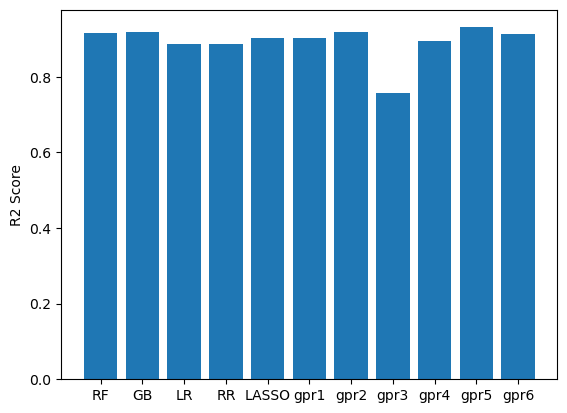

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'X_IEII', 'A_Rvdw', 'A_IEI', 'A_ChiA',
       'B_Hf', 'A_ChiP', 'X_G'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9137243049565906
RMSE:  0.2937272460011317
---------------------------------------
GB
R2:  0.8663980816167061
RMSE:  0.3655159618721102
---------------------------------------
LR
R2:  0.8960627618127741
RMSE:  0.32239298718679643
---------------------------------------
RR
R2:  0.8961165106086135
RMSE:  0.32230961728032026
---------------------------------------
LASSO
R2:  0.8987957283547783
RMSE:  0.3181261882417442
---------------------------------------
gpr1
R2:  0.9044487787893452
RMSE:  0.3091136056705607
---------------------------------------
gpr2
R2:  0.9030023958189493
RMSE:  0.3114443837686766
---------------------------------------
gpr3
R2:  0.11190451161817627
RMSE:  0.9423881834901283
---------------------------------------
gpr4
R2:  0.20682010558191066
RMSE:  0.8906064756210171
---------------------------------------
gpr5
R2:  0.8677869653735392
RMSE:  0.36361110355221665
---------------------------------------
gpr6
R2:  0.9077690338280667
RMSE:  0.30369551556111

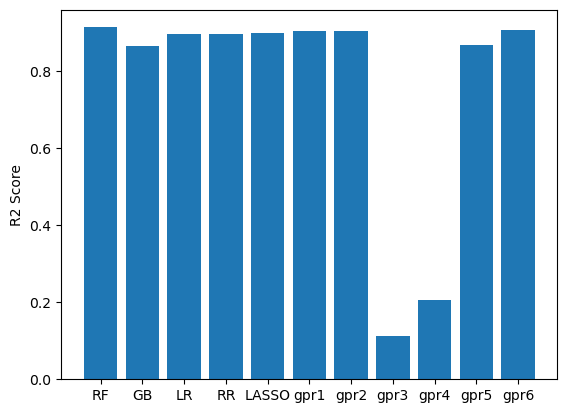

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_A.csv', encoding='cp1252')

In [24]:
data_mm.drop(['density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
           'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_A'] 
X = data_mm.drop(['Coeff_A','Name'], axis=1)

### Using CV technique

RF
R2:  0.9109467868355502
RMSE:  0.08056402576186833
---------------------------------------
GB
R2:  0.9049579301314912
RMSE:  0.08322892890982322
---------------------------------------
LR
R2:  -4.19478690092104e+23
RMSE:  174852285848.42633
---------------------------------------
RR
R2:  0.8907980554639575
RMSE:  0.0892136994094055
---------------------------------------
LASSO
R2:  0.830977695209371
RMSE:  0.11099115540472551
---------------------------------------
gpr1
R2:  0.8148532780509667
RMSE:  0.11616475378177726
---------------------------------------
gpr2
R2:  0.9494169052493393
RMSE:  0.060718224130938116
---------------------------------------
gpr3
R2:  0.9223064872117333
RMSE:  0.07525038765535685
---------------------------------------
gpr4
R2:  0.9223064791718247
RMSE:  0.07525039154890083
---------------------------------------
gpr5
R2:  0.9309906732557726
RMSE:  0.07092025000163303
---------------------------------------
gpr6
R2:  0.9069390606974688
RMSE:  0.08235691

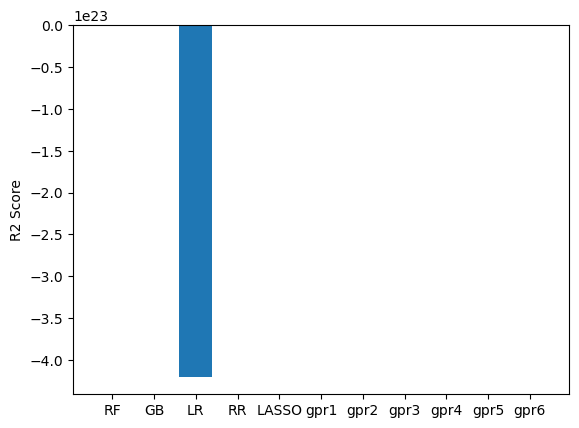

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

    Feature       Score
14     X_EA  112.702665
2       X_Z  106.612941
22   X_Rvdw   86.120704
20   A_Rvdw   56.376662
6     A_IEI   38.414491
18   A_ChiA   33.512107
11   X_IEII   19.080411
32     B_Hf   18.081523
15   A_ChiP   17.250853
5       X_G   15.282633
26     B_MP   14.690246
24     B_Ra   13.703676
25     A_MP   13.495857
12     A_EA   11.836644
0       A_Z   11.590484
29    X_Rho   11.571776
1       B_Z   11.204890
35  X_Kappa    9.959958
36    A_CvM    8.849576
33  A_Kappa    8.078728
19   B_ChiA    7.713379
34  B_Kappa    7.615863
31     X_MV    7.419386
30     B_MV    7.256271
38      A_B    5.603181
3       A_G    4.843449
37    B_CvM    4.350412
28    B_Rho    4.184881
13     B_EA    3.862307
8     X_IEI    3.594946


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'X_IEII',
       'B_Hf', 'A_ChiP', 'X_G', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'A_Z',
       'X_Rho', 'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_ChiA', 'B_Kappa',
       'X_MV', 'B_MV', 'A_B', 'A_G', 'B_CvM', 'B_Rho', 'B_EA', 'X_IEI',
       'B_Rvdw', 'B_Rc', 'B_ChiP', 'A_Rho', 'B_G', 'B_IEI', 'B_IEII',
       'B_MendeleevNo', 'X_ChiP', 'A_IEII'], dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.9076971655460797
RMSE:  0.08202077743956199
---------------------------------------
GB
R2:  0.8918583436394848
RMSE:  0.08877953607312529
---------------------------------------
LR
R2:  -5.498542065509654e+22
RMSE:  63305309819.3659
---------------------------------------
RR
R2:  0.8455341147610733
RMSE:  0.10610421862918049
---------------------------------------
LASSO
R2:  0.8309824533287143
RMSE:  0.11098959314677131
---------------------------------------
gpr1
R2:  0.6983755433405539
RMSE:  0.1482687543504307
---------------------------------------
gpr2
R2:  0.948071639064959
RMSE:  0.06152033193110183
---------------------------------------
gpr3
R2:  0.6986961711701785
RMSE:  0.1481899283001363
---------------------------------------
gpr4
R2:  0.9268796275944328
RMSE:  0.0730021347294911
---------------------------------------
gpr5
R2:  0.9332581697576656
RMSE:  0.06974537579761347
---------------------------------------
gpr6
R2:  0.908038580535553
RMSE:  0.0818689453429

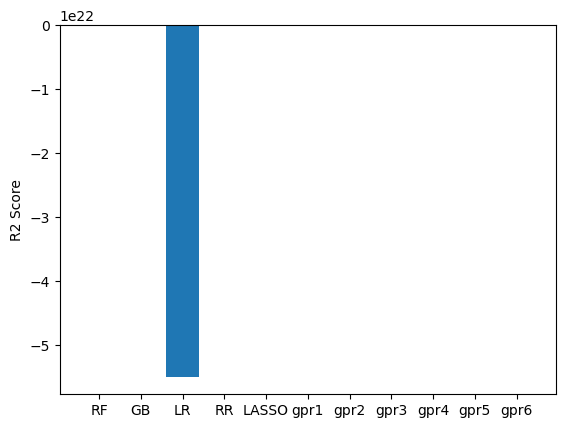

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'X_IEII',
       'B_Hf', 'A_ChiP', 'X_G', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'A_Z',
       'X_Rho', 'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa', 'B_ChiA', 'B_Kappa',
       'X_MV', 'B_MV', 'A_B', 'A_G', 'B_CvM', 'B_Rho', 'B_EA', 'X_IEI'],
      dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.917805170723806
RMSE:  0.07739958133230027
---------------------------------------
GB
R2:  0.907855098826352
RMSE:  0.08195057723197353
---------------------------------------
LR
R2:  -5.432040104964747e+19
RMSE:  1989746944.6430497
---------------------------------------
RR
R2:  0.8920582736954661
RMSE:  0.08869743122275853
---------------------------------------
LASSO
R2:  0.8309824632253716
RMSE:  0.1109895898973277
---------------------------------------
gpr1
R2:  0.86772468492659
RMSE:  0.0981874011098857
---------------------------------------
gpr2
R2:  0.9390722785791513
RMSE:  0.066638287978664
---------------------------------------
gpr3
R2:  0.8685873516693408
RMSE:  0.09786670045376603
---------------------------------------
gpr4
R2:  0.8685873534274507
RMSE:  0.097866699799109
---------------------------------------
gpr5
R2:  0.9203863428693385
RMSE:  0.07617459426855915
---------------------------------------
gpr6
R2:  0.9207784206456514
RMSE:  0.0759867921466034

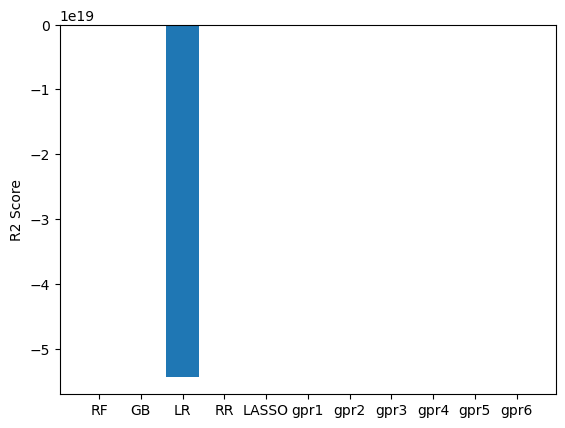

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'X_IEII',
       'B_Hf', 'A_ChiP', 'X_G', 'B_MP', 'B_Ra', 'A_MP', 'A_EA', 'A_Z',
       'X_Rho', 'B_Z', 'X_Kappa', 'A_CvM', 'A_Kappa'], dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.9083188220374022
RMSE:  0.08174410722013714
---------------------------------------
GB
R2:  0.8915545654560401
RMSE:  0.0889041428803465
---------------------------------------
LR
R2:  0.8890669060120321
RMSE:  0.08991805943043193
---------------------------------------
RR
R2:  0.8891320405698624
RMSE:  0.08989165778243188
---------------------------------------
LASSO
R2:  0.8309824498650992
RMSE:  0.11098959428400602
---------------------------------------
gpr1
R2:  0.8998237087141313
RMSE:  0.08544739700154146
---------------------------------------
gpr2
R2:  0.9334093225640425
RMSE:  0.06966635350491347
---------------------------------------
gpr3
R2:  0.7420205783836211
RMSE:  0.13712255442123625
---------------------------------------
gpr4
R2:  0.8901407580012665
RMSE:  0.08948178970375527
---------------------------------------
gpr5
R2:  0.9341203571747881
RMSE:  0.06929341744606983
---------------------------------------
gpr6
R2:  0.9278862602220599
RMSE:  0.0724978908

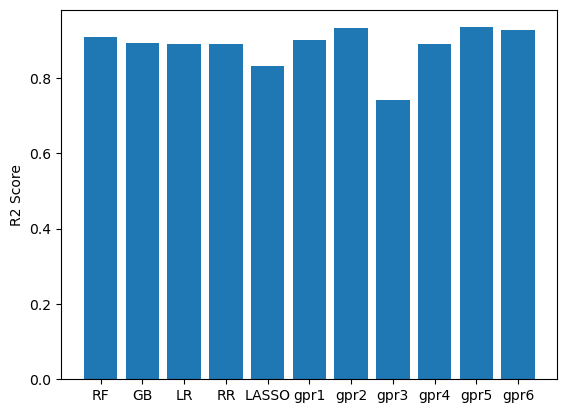

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Z', 'X_Rvdw', 'A_Rvdw', 'A_IEI', 'A_ChiA', 'X_IEII',
       'B_Hf', 'A_ChiP', 'X_G'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.9176580850495086
RMSE:  0.07746880272523081
---------------------------------------
GB
R2:  0.8836574835109796
RMSE:  0.09208429963173333
---------------------------------------
LR
R2:  0.898178086653911
RMSE:  0.08614637147203236
---------------------------------------
RR
R2:  0.8980574666995772
RMSE:  0.08619738159128387
---------------------------------------
LASSO
R2:  0.8074316129175034
RMSE:  0.11847012837719112
---------------------------------------
gpr1
R2:  0.8954097927783209
RMSE:  0.08730957503572902
---------------------------------------
gpr2
R2:  0.8988797357934313
RMSE:  0.08584904344251099
---------------------------------------
gpr3
R2:  -1.0839505324554137
RMSE:  0.38972661509052375
---------------------------------------
gpr4
R2:  -0.49936114789718067
RMSE:  0.3305746061292373
---------------------------------------
gpr5
R2:  0.8015297151541639
RMSE:  0.12027188264559723
---------------------------------------
gpr6
R2:  0.9077934772510305
RMSE:  0.08197797

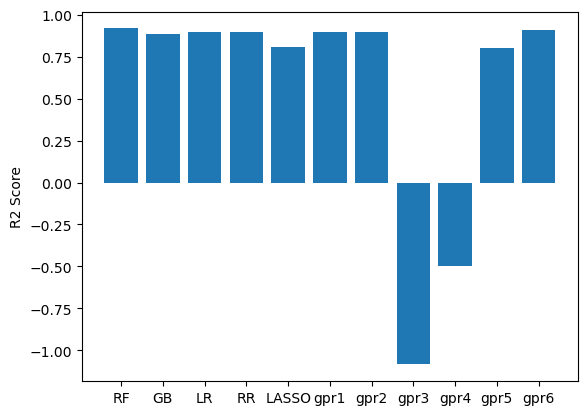

In [40]:
run_models()